In [1]:
# Import Required Packages
import numpy as np
import math
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import SimpleITK as sitk
from scipy import ndimage
import glob
import pandas as pd
import pylab

In [2]:
# Downloaded Packages
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import BCELoss
import segmentation_models_pytorch as smp
import torch.optim as optim
import shutil

# Custom written .py files
from helper import ground_truth_files, mask_images
from clubfoot_transforms import *
from pytorchclubfootdataset import *
from clubfoot_training import *

base_dir = 'C:\\Users\\danie\\OneDrive\\Documents\\Clubfoot\\GroundTruthSegmentation\\Final_Seg_Maps_NIFTI2'

In [98]:
print(os.getcwd())
base = os.path.join(base_dir, 'Data')
data = ground_truth_files(base, ['LAT']) # clubfoot_type = 'AP','LAT' 

C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Results\Plantar_Surface


In [99]:
print(len(data))

230


In [100]:
os.chdir(base_dir)
# Training, Test, and Validation
split = pd.read_csv('Clubfoot_Update_012521.csv')

split['Folder ID'] = split['Folder ID'].astype(str)
data_2 = data.merge(split, left_on='folder', right_on='Folder ID', how='inner')
data_2 = data_2.drop(columns = ['Folder ID'])

training_data = data_2[data_2['Split'] == 'Training']
validation_data = data_2[data_2['Split'] == 'Validation']
validation_data = validation_data.reset_index()

# Clubfoot_Update_012521
print(' The training data size is: ', len(training_data),'\n',
      'The validation data size is: ', len(validation_data), '\n')


 The training data size is:  136 
 The validation data size is:  25 



In [101]:
pd.options.display.max_colwidth = 115
validation_data.nifti_path

0     C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Data\ClubFoot\16\LAT_F...
1     C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Data\ClubFoot\21\LAT_F...
2     C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Data\ClubFoot\52\LAT_F...
3     C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Data\ClubFoot\64\LAT_F...
4     C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Data\ClubFoot\68\LAT_F...
5     C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Data\Normals\121\121_L...
6     C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Data\Normals\122\122_L...
7     C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2\Data\Normals\128\128_L...
8     C:\Users\danie\OneDrive\Do

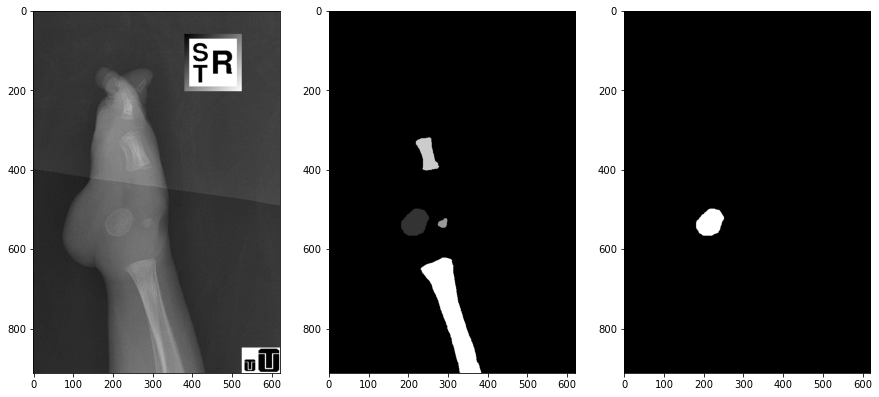

In [34]:
def input_calcaneus_tibia(label):
    # Grabbing labeled bones from the gorund truth image
    b = (label == 1) # calcanues
    c = (label == 2) # calcaneus-talus overlap
    d = (label == 3) # talus
    calcaneus = b.astype(int) + c.astype(int) # Calcanues
    talus = c.astype(int) + d.astype(int) # Talus
    #tibia = (label == 5) # tibia
    return calcaneus, talus #tibia

def axis_finder(img):
    '''
    Function to return the long and short axis through 
    the center of a blob
    '''
    y, x = np.nonzero(img)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])  # Stack arrays in sequence vertically (row wise).
    cov = np.cov(coords) # Estimate a covariance matrix, given data and weights
    evals, evecs = np.linalg.eig(cov) # Compute the eigenvalues and right eigenvectors of a square array.
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    return [x_v1, y_v1, x_v2, y_v2, x, y]


def sub_plot(eigen_data, scale, x, y, col):
    plt.plot([eigen_data[0]*-scale*10 + x, eigen_data[0]*scale*10 + x],
             [eigen_data[1]*-scale*10 + y, eigen_data[1]*scale*10 + y], color=col)  
def y_eq(val, slope, neg_x_r, neg_y_r):
    y = slope * (val - neg_x_r) + neg_y_r
    return y

def calcaneusplantarsurface(calcaneus, tibia, calcaneus_data):
    # Create a Line that stop at the first black point on the stucture 
    # Positive Step
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y, x = ndimage.measurements.center_of_mass(calcaneus)
    y_r, x_r = round(y), round(x)

    positive_step = []
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r + calcaneus_data[0]*1
        y_r = y_r + calcaneus_data[1]*1
        positive_step.append(plantar_surf_finder(y_r, x_r, y_tib, x_tib, calcaneus_data))

    # Negative Step
    y_r = round(y) 
    x_r = round(x)
    negative_step = []
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r - calcaneus_data[0]*1
        y_r = y_r - calcaneus_data[1]*1
        negative_step.append(plantar_surf_finder(y_r, x_r, y_tib, x_tib, calcaneus_data))

    cols = ['x_r', 'y_r','x', 'y', 'd']
    positive_step_df = pd.DataFrame(positive_step, columns = cols)
    negative_step_df = pd.DataFrame(negative_step, columns = cols)
    neg = negative_step_df[negative_step_df.d  == negative_step_df.d.max()]
    pos = positive_step_df[positive_step_df.d  == positive_step_df.d.max()]

    scale = 100
    slope = (neg.y_r.item() - pos.y_r.item())/(neg.x_r.item() -  pos.x_r.item())
    
    if (round(x) + 100) > calcaneus.shape[0]:
        x_1 = calcaneus.shape[0] - 5
    else:
        x_1 = round(x) + 5
    
    x_2 = round(x) - 5
    y_1, y_2 = y_eq(x_1, slope, neg.x_r.item(), neg.y_r.item()), y_eq(x_2, slope, neg.x_r.item(), neg.y_r.item())
    return x_1, x_2, y_1, y_2


num = 1
nifti = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
nifti_arr = sitk.GetArrayViewFromImage(nifti)
vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
vtk_arr = sitk.GetArrayViewFromImage(vtk)
calcaneus, tibia = input_calcaneus_tibia(vtk_arr)

f, axarr = plt.subplots(1,3, figsize = (15,10)) 
axarr[0].imshow(nifti_arr[0,], cmap='gray') # [0,]
axarr[1].imshow(vtk_arr, cmap='gray')
axarr[2].imshow(calcaneus, cmap='gray')

In [35]:
##############################################################
# Try 1
##############################################################

os.chdir(os.path.join(base_dir,'Results','Plantar_Surface'))
def midpoint(p1, p2):
    return (p1[0]+p2[0])/2, (p1[1]+p2[1])/2


# Function to return the distance 
# Perpendicular Slope to a line (m) == (-1/m)
def plantar_surf_finder(y, x, y_tib, x_tib, y_orig, x_orig, calcaneus_data):
    y_r = round(y)
    x_r = round(x)
    
    if abs(calcaneus_data[1]) <= abs(calcaneus_data[0]):
        if (y_tib - y_orig) <= 0: 
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r - calcaneus_data[1]*2
                y_r = y_r + calcaneus_data[0]*2
        else:
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r + calcaneus_data[1]*2
                y_r = y_r - calcaneus_data[0]*2
    
    if abs(calcaneus_data[1]) > abs(calcaneus_data[0]):
        if (x_tib - x_orig) <= 0: 
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r - calcaneus_data[1]*2
                y_r = y_r + calcaneus_data[0]*2
        else:
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r + calcaneus_data[1]*2
                y_r = y_r - calcaneus_data[0]*2
    d = ((x_r - x)**2 + (y_r - y)**2)**(1/2)
    return [round(x_r), round(y_r), round(x), round(y), d]

def calcaneusplantarsurface(calcaneus, tibia, calcaneus_data):
    # Create a Line that stop at the first black point on the stucture 
    # Positive Step
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y, x = ndimage.measurements.center_of_mass(calcaneus)
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y_r, x_r = round(y), round(x)
    

    #print((y_tib - y_r), (x_tib - x_r))
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r + calcaneus_data[0]*1
        y_r = y_r + calcaneus_data[1]*1
    p1 = [x_r, y_r]
    
    y_r, x_r = round(y), round(x)
    #print(y_r, x_r)
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r - calcaneus_data[0]*1
        y_r = y_r - calcaneus_data[1]*1
    p2 = [x_r, y_r]
    mid_pt = midpoint(p1, p2)
    
    y_r, x_r = round(y), round(mid_pt[0])
    positive_step = []
    #print(y_r, x_r)
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r + calcaneus_data[0] *2
        y_r = y_r + calcaneus_data[1] *2
        positive_step.append(plantar_surf_finder(y_r, x_r, y_tib, x_tib, round(y), round(x), calcaneus_data))

    # Negative Step
    y_r, x_r = round(y), round(mid_pt[0])
    negative_step = []
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r - calcaneus_data[0] * 2
        y_r = y_r - calcaneus_data[1] * 2
        negative_step.append(plantar_surf_finder(y_r, x_r, y_tib, x_tib, round(y), round(x), calcaneus_data))

    cols = ['x_r', 'y_r','x', 'y', 'd']
    positive_step_df = pd.DataFrame(positive_step, columns = cols)
    negative_step_df = pd.DataFrame(negative_step, columns = cols)
    #print(negative_step_df.x_r.min(), negative_step_df.x_r.max())
    all_data = pd.concat([positive_step_df, negative_step_df])
    neg = negative_step_df[negative_step_df.d  == negative_step_df.d.max()]
    pos = positive_step_df[positive_step_df.d  == positive_step_df.d.max()]
    #print(neg)

    scale = 100
    slope = (neg.y_r.item() - pos.y_r.item())/(neg.x_r.item() -  pos.x_r.item())
    
    if (round(x) + 100) > calcaneus.shape[0]:
        x_1 = calcaneus.shape[0] - 5
    else:
        x_1 = round(x) + 100
    
    x_2 = round(x) - 100
    y_1, y_2 = y_eq(x_1, slope, neg.x_r.item(), neg.y_r.item()), y_eq(x_2, slope, neg.x_r.item(), neg.y_r.item())
    return x_1, x_2, y_1, y_2, neg, pos, all_data


for num in range(25):
    save_name = os.path.basename(validation_data['nifti_path'].iloc[num])
    print(save_name)
    nifti = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
    nifti_arr = sitk.GetArrayViewFromImage(nifti)
    vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
    vtk_arr = sitk.GetArrayViewFromImage(vtk)
    calcaneus, tibia = input_calcaneus_tibia(vtk_arr)
    calcaneus_data = axis_finder(calcaneus) # calcaneus_data
    print(calcaneus_data[1], calcaneus_data[0])
    plt.figure(figsize = (15, 15), frameon = False)
    plt.imshow(nifti_arr[0,], cmap='gray')
    x_1, x_2, y_1, y_2, neg, pos, all_data = calcaneusplantarsurface(calcaneus, tibia, calcaneus_data)
    plt.plot([neg.x_r.item(), neg.x.item()], [neg.y_r.item(), neg.y.item()], color = 'blue')
    plt.plot([pos.x_r.item(), pos.x.item()], [pos.y_r.item(), pos.y.item()], color = 'blue')
    #print(save_name, ndimage.measurements.center_of_mass(calcaneus), '\n')

    sub_plot(calcaneus_data, 20, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')
    plt.plot([x_1, x_2], [y_1, y_2], color = 'red')
    plt.savefig('val_' + save_name[:-4] + '.jpg')
    plt.close('all')

LAT_FOOT_0153.nii
0.3423566254949263 0.9395700830591228
LAT_FOOT_8582.nii
-0.7294353721272427 0.684049733491353
LAT_FOOT_7471.nii
-0.4453900545801666 0.8953366401980187
LAT_FOOT_5837.nii
-0.9923737620076977 0.12326522818171205
LAT_FOOT_1356.nii
-0.312977013171851 0.949760701032648
121_LAT_FOOT_1316.nii
0.02005714919016351 0.9997988351495334
122_LAT_FOOT_8796.nii
-0.6648490465433975 0.7469777408399366
128_LAT_FOOT_4340.nii
-0.9868930679522394 -0.16137556329202019
133_LAT_FOOT_3782.nii
-0.37699527408778566 0.9262151819720272
138_LAT_FOOT_7698.nii
-0.7979397587626009 -0.6027372075671804
141_LAT_FOOT_5406.nii
0.14379345767892168 0.9896077210333093
142_LAT_FOOT_2444.nii
0.05888392552340618 0.9982648362608761
143_LAT_FOOT_8240.nii
0.5825302630790433 0.8128090136047094
144_LAT_FOOT_9412.nii
-0.7219250231919211 0.691971286174032
146_LAT_FOOT_4724.nii
-0.4839336573855884 0.8751046881655977
161_LAT_FOOT_6716.nii
0.040637153914962525 0.9991739696978159
173_LAT_FOOT_6406.nii
-0.8518423565164835 0.

In [37]:
# Try 2 
os.chdir(os.path.join(base_dir,'Results','Plantar_Surface'))
def midpoint(p1, p2):
    return (p1[0]+p2[0])/2, (p1[1]+p2[1])/2


# Function to return the distance 
# Perpendicular Slope to a line (m) == (-1/m)
def plantar_surf_finder(y, x, y_tib, x_tib, y_orig, x_orig, calcaneus_data):
    y_r = round(y)
    x_r = round(x)
    
    if abs(calcaneus_data[1]) <= abs(calcaneus_data[0]):
        if (y_tib - y_orig) <= 0: 
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r - calcaneus_data[1]*2
                y_r = y_r + calcaneus_data[0]*2
        else:
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r + calcaneus_data[1]*2
                y_r = y_r - calcaneus_data[0]*2
    
    if abs(calcaneus_data[1]) > abs(calcaneus_data[0]):
        if (x_tib - x_orig) <= 0: 
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r - calcaneus_data[1]*2
                y_r = y_r + calcaneus_data[0]*2
        else:
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r + calcaneus_data[1]*2
                y_r = y_r - calcaneus_data[0]*2
    d = ((x_r - x)**2 + (y_r - y)**2)**(1/2)
    return [round(x_r), round(y_r), round(x), round(y), d]


def calcaneusplantarsurface(calcaneus, tibia, calcaneus_data):
    # Create a Line that stop at the first black point on the stucture 
    # Positive Step
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y, x = ndimage.measurements.center_of_mass(calcaneus)
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y_r, x_r = round(y), round(x)
    
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r - calcaneus_data[0]*1
        y_r = y_r - calcaneus_data[1]*1
    p2 = [x_r + calcaneus_data[0]*1, y_r + calcaneus_data[1]*1]
    y_r, x_r = p2[1], p2[0]    
    positive_step = []

    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r + calcaneus_data[0] *2
        y_r = y_r + calcaneus_data[1] *2
        positive_step.append(plantar_surf_finder(y_r, x_r, y_tib, x_tib, round(y), round(x), calcaneus_data))

    cols = ['x_r', 'y_r','x', 'y', 'd']
    positive_step_df = pd.DataFrame(positive_step, columns = cols)
    return positive_step_df

def calcaneusplantarsurface(calcaneus, tibia, calcaneus_data):
    # Create a Line that stop at the first black point on the stucture 
    # Positive Step
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y, x = ndimage.measurements.center_of_mass(calcaneus)
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y_r, x_r = round(y), round(x)
    
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r - calcaneus_data[0]*1
        y_r = y_r - calcaneus_data[1]*1
    p2 = [x_r + calcaneus_data[0], y_r + calcaneus_data[1]]
    
    y_r, x_r = round(p2[1]), round(p2[0])
    print(p2)
    positive_step = []
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r + calcaneus_data[0] *2
        y_r = y_r + calcaneus_data[1] *2
        positive_step.append(plantar_surf_finder(y_r, x_r, y_tib, x_tib, round(y), round(x), calcaneus_data))

    cols = ['x_r', 'y_r','x', 'y', 'd']
    positive_step_df = pd.DataFrame(positive_step, columns = cols)
    return positive_step_df

for num in range(0,25):
    save_name = os.path.basename(validation_data['nifti_path'].iloc[num])
    nifti = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
    nifti_arr = sitk.GetArrayViewFromImage(nifti)
    vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
    vtk_arr = sitk.GetArrayViewFromImage(vtk)
    calcaneus, talus = input_calcaneus_tibia(vtk_arr)
    calcaneus_data = axis_finder(calcaneus)
    talus_data = axis_finder(talus)
 
    # Plotting the figure
    plt.figure(figsize = (15, 15), frameon = False)
    plt.imshow(nifti_arr[0,], cmap='gray')
    sub_plot(calcaneus_data, 5, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')
    
    # Talus Data 
    sub_plot(talus_data, 15, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    
    pos = calcaneusplantarsurface(calcaneus, talus, calcaneus_data)
    #print(pos)
    plt.plot(pos.x_r, pos.y_r)
    
    # Definine the line
    df_15_85 = pos.iloc[round(.05 * len(pos)):round(.85 * len(pos))]
    
    m, b = np.polyfit(df_15_85.x_r, df_15_85.y_r, 1)
    #m, b = np.polyfit(df_15_85.x, df_15_85.d, 1)
    #plt.plot(df_15_85.x, df_15_85.d)
    print(save_name, 'Slope and Intercept: ', m, b)
    print(pos.x.min(), pos.x.max())
    print(df_15_85.x.min(), df_15_85.x.max())
    print(df_15_85.x.iloc[0], df_15_85.x.iloc[-1])
    
    print(calcaneus_data[1], calcaneus_data[0])
    if abs(calcaneus_data[1]) <= abs(calcaneus_data[0]):
        print('X larger than Y')
    if abs(calcaneus_data[1]) > abs(calcaneus_data[0]):
        print('Y larger than X')
    print('\n')
    
    #if abs(calcaneus_data[1]) <= abs(calcaneus_data[0]):
    #    x_1, x_2 = df_15_85.x.iloc[0], df_15_85.x.iloc[-1]
    #    print(x_1, x_2)
    #    y_1, y_2 = ((m * x_1) + b), ((m * x_2) + b) # + df_15_85.y.iloc[0]+ df_15_85.y.iloc[-1]
    #    print('Ba', y_1, y_2)
    #if abs(calcaneus_data[1]) > abs(calcaneus_data[0]):
    #    x_1, x_2 = df_15_85.x.iloc[0], df_15_85.x.iloc[-1]
    #    y_1, y_2 = df_15_85.y.iloc[0] - ((m * x_1) + b), df_15_85.y.iloc[-1] - ((m * x_2) + b)# + df_15_85.y.iloc[0] + df_15_85.y.iloc[-1]
    #    print('LA', y_1, y_2)
    #    print('xs', x_1, x_2)

    #print(x_1, y_1, x_2, y_2)
    if abs(calcaneus_data[1]) <= abs(calcaneus_data[0]):
        x_1, x_2 = df_15_85.x_r.min(), df_15_85.x_r.max()
        y_1, y_2 = ((m * x_1) + b), ((m * x_2) + b)
    
    if abs(calcaneus_data[1]) > abs(calcaneus_data[0]):
        y_1, y_2 = df_15_85.y_r.min(), df_15_85.y_r.max()
        x_1, x_2 = (y_1 - b)/m, (y_2 - b)/m
    
    plt.plot([x_1, x_2], [y_1, y_2], color = 'red')
    plt.savefig('val_try_2_' + save_name[:-4] + '.jpg')
    plt.close('all')

[236.2300941858627, 683.035036215352]
LAT_FOOT_0153.nii Slope and Intercept:  0.46801273447786806 611.7332327254453
238 364
244 345
244 345
0.3423566254949263 0.9395700830591228
X larger than Y


[190.69015986082007, 560.9891087687074]
LAT_FOOT_8582.nii Slope and Intercept:  -1.050007988496566 720.6682217606647
192 243
195 235
195 235
-0.7294353721272427 0.684049733491353
Y larger than X


[209.90778174693037, 669.3957436022877]
LAT_FOOT_7471.nii Slope and Intercept:  -0.525205081541779 821.3590959547516
212 332
217 314
217 314
-0.4453900545801666 0.8953366401980187
X larger than Y


[428.38531220182676, 846.4051534365985]
LAT_FOOT_5837.nii Slope and Intercept:  -2.066471656243404 1603.788480935934
428 446
429 443
429 443
-0.9923737620076977 0.12326522818171205
Y larger than X


[315.8779979791822, 439.61831054110763]
LAT_FOOT_1356.nii Slope and Intercept:  -0.36956739981647385 618.6387853465143
318 546
329 512
329 512
-0.312977013171851 0.949760701032648
X larger than Y


[853.0197141

In [103]:
# Try 3
os.chdir(os.path.join(base_dir,'Results','Plantar_Surface'))
def midpoint(p1, p2):
    return (p1[0]+p2[0])/2, (p1[1]+p2[1])/2



# Function to return the distance 
# Perpendicular Slope to a line (m) == (-1/m)
def plantar_surf_finder(y, x, y_tib, x_tib, y_orig, x_orig, calcaneus_data):
    y_r = round(y)
    x_r = round(x)
    
    if abs(calcaneus_data[1]) <= abs(calcaneus_data[0]):
        if (y_tib - y_orig) <= 0: 
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r - calcaneus_data[1]*2
                y_r = y_r + calcaneus_data[0]*2
        else:
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r + calcaneus_data[1]*2
                y_r = y_r - calcaneus_data[0]*2
    
    if abs(calcaneus_data[1]) > abs(calcaneus_data[0]):
        if (x_tib - x_orig) <= 0: 
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r - calcaneus_data[1]*2
                y_r = y_r + calcaneus_data[0]*2
        else:
            while calcaneus[round(y_r), round(x_r)] == 1:
                x_r = x_r + calcaneus_data[1]*2
                y_r = y_r - calcaneus_data[0]*2
    d = ((x_r - x)**2 + (y_r - y)**2)**(1/2)
    return [round(x_r), round(y_r), round(x), round(y), d]


def calcaneusplantarsurface(calcaneus, tibia, calcaneus_data):
    # Create a Line that stop at the first black point on the stucture 
    # Positive Step
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y, x = ndimage.measurements.center_of_mass(calcaneus)
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y_r, x_r = round(y), round(x)
    
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r - calcaneus_data[0]*1
        y_r = y_r - calcaneus_data[1]*1
    p2 = [x_r + calcaneus_data[0]*1, y_r + calcaneus_data[1]*1]
    y_r, x_r = p2[1], p2[0]    
    positive_step = []

    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r + calcaneus_data[0] *2
        y_r = y_r + calcaneus_data[1] *2
        positive_step.append(plantar_surf_finder(y_r, x_r, y_tib, x_tib, round(y), round(x), calcaneus_data))

    cols = ['x_r', 'y_r','x', 'y', 'd']
    positive_step_df = pd.DataFrame(positive_step, columns = cols)
    return positive_step_df

def calcaneusplantarsurface(calcaneus, tibia, calcaneus_data):
    # Create a Line that stop at the first black point on the stucture 
    # Positive Step
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y, x = ndimage.measurements.center_of_mass(calcaneus)
    y_tib, x_tib = ndimage.measurements.center_of_mass(tibia)
    y_r, x_r = round(y), round(x)
    
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r - calcaneus_data[0]*1
        y_r = y_r - calcaneus_data[1]*1
    p2 = [x_r + calcaneus_data[0], y_r + calcaneus_data[1]]
    
    y_r, x_r = round(p2[1]), round(p2[0])
    #print(p2)
    positive_step = []
    while calcaneus[round(y_r), round(x_r)] == 1:
        x_r = x_r + calcaneus_data[0] *2
        y_r = y_r + calcaneus_data[1] *2
        positive_step.append(plantar_surf_finder(y_r, x_r, y_tib, x_tib, round(y), round(x), calcaneus_data))

    cols = ['x_r', 'y_r','x', 'y', 'd']
    positive_step_df = pd.DataFrame(positive_step, columns = cols)
    return positive_step_df

for num in range(0,25):
    save_name = os.path.basename(validation_data['nifti_path'].iloc[num])
    nifti = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
    nifti_arr = sitk.GetArrayViewFromImage(nifti)
    vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
    vtk_arr = sitk.GetArrayViewFromImage(vtk)
    calcaneus, talus = input_calcaneus_tibia(vtk_arr)
    calcaneus_data = axis_finder(calcaneus)
    talus_data = axis_finder(talus)
 
    # Plotting the figure
    plt.figure(figsize = (15, 15), frameon = False)
    plt.imshow(nifti_arr[0,], cmap='gray')
    sub_plot(calcaneus_data, 5, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')
    
    # Talus Data 
    sub_plot(talus_data, 15, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    
    pos = calcaneusplantarsurface(calcaneus, talus, calcaneus_data)
    #print(pos)
    plt.plot(pos.x_r, pos.y_r)
    
    # Definine the line
    df_10_35 = pos.iloc[round(.10 * len(pos)):round(.35 * len(pos))]
    df_65_90 = pos.iloc[round(.65 * len(pos)):round(.90 * len(pos))]
    neg = df_10_35[df_10_35.d  == df_10_35.d.max()]
    pos = df_65_90[df_65_90.d  == df_65_90.d.max()]
    scale = 100
    slope = (neg.y_r.item() - pos.y_r.item())/(neg.x_r.item() -  pos.x_r.item())
    plt.plot([neg.x_r.item(), neg.x.item()], [neg.y_r.item(), neg.y.item()], color = 'blue')
    plt.plot([pos.x_r.item(), pos.x.item()], [pos.y_r.item(), pos.y.item()], color = 'blue')
    
    if df_10_35.x_r.min() <= df_65_90.x_r.min():        
        x_1 = df_10_35.x_r.min() - 20#iloc[0]
        x_2 = df_65_90.x_r.max() + 20#iloc[-1]
    
    if df_10_35.x_r.min() > df_65_90.x_r.min():        
        x_1 = df_10_35.x_r.min() + 20#iloc[0]
        x_2 = df_65_90.x_r.max() - 20#iloc[-1]
    
    
    y_1, y_2 = y_eq(x_1, slope, neg.x_r.item(), neg.y_r.item()), y_eq(x_2, slope, neg.x_r.item(), neg.y_r.item())
    plt.plot([x_1, x_2], [y_1, y_2], color = 'red')
    plt.savefig('val_try_3_' + save_name[:-4] + '.jpg')
    plt.close('all')

<ipython-input-132-a6a7fedcf9e9>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize = (5, 5), frameon = False)


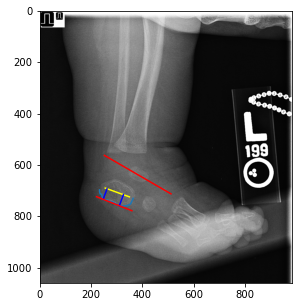

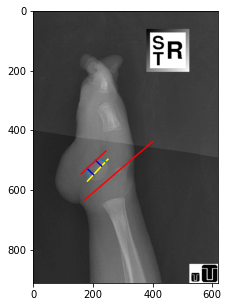

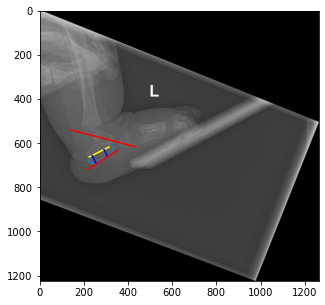

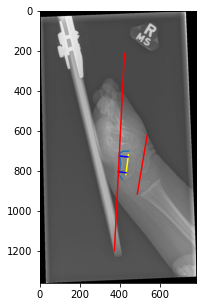

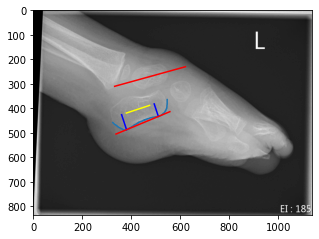

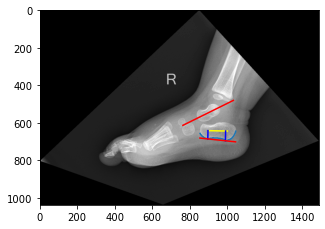

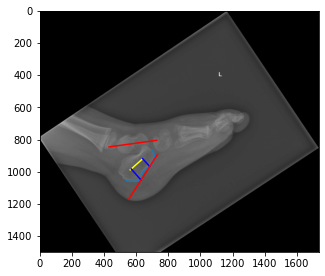

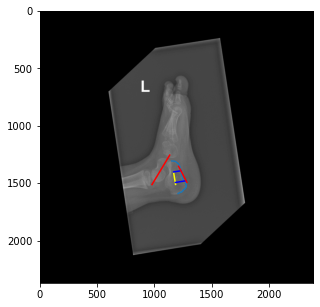

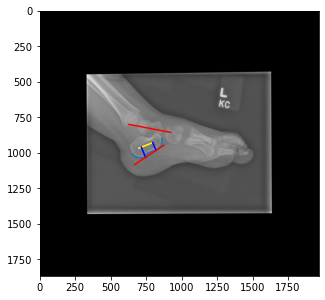

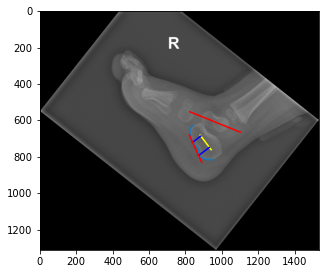

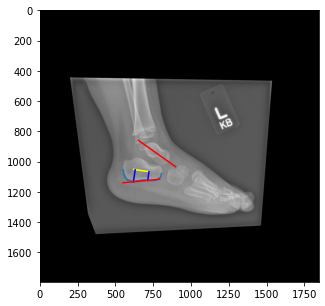

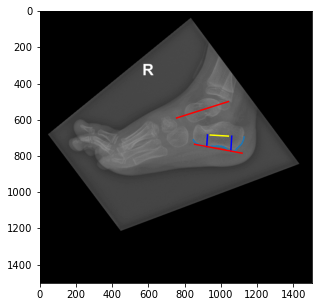

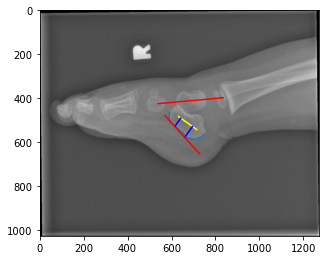

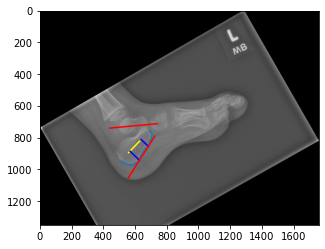

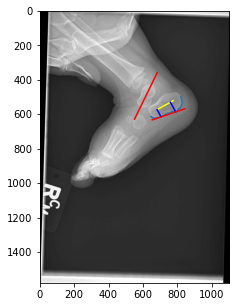

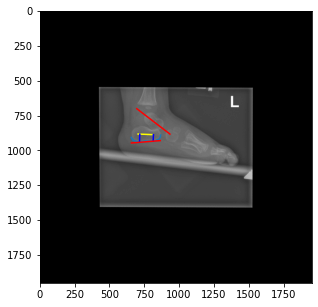

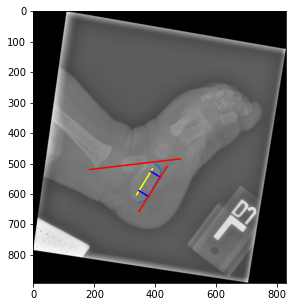

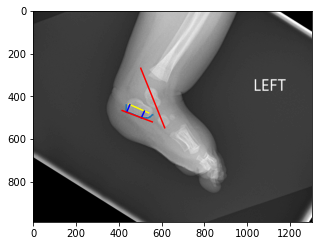

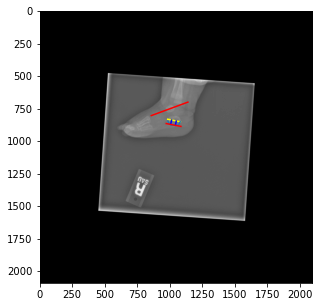

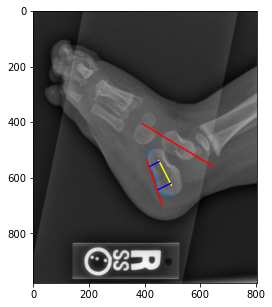

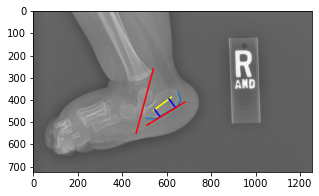

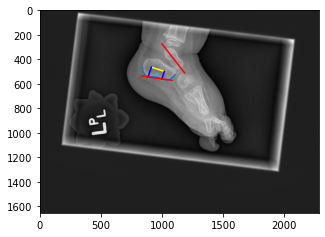

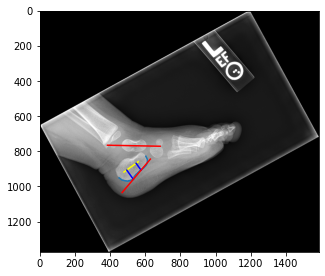

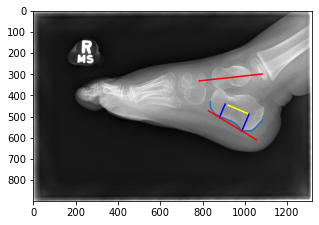

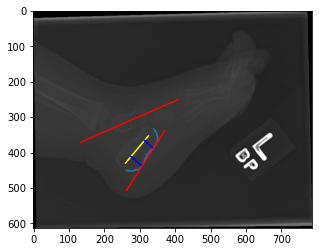

In [132]:
lat_data = []
for num in range(0,25):
    save_name = os.path.basename(validation_data['nifti_path'].iloc[num])
    nifti = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
    nifti_arr = sitk.GetArrayViewFromImage(nifti)
    vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
    vtk_arr = sitk.GetArrayViewFromImage(vtk)
    calcaneus, talus = input_calcaneus_tibia(vtk_arr)
    calcaneus_data = axis_finder(calcaneus)
    talus_data = axis_finder(talus)
 
    # Plotting the figure
    plt.figure(figsize = (5, 5), frameon = False)
    plt.imshow(nifti_arr[0,], cmap='gray')
    sub_plot(calcaneus_data, 5, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')
    
    # Talus Data 
    sub_plot(talus_data, 15, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    
    pos = calcaneusplantarsurface(calcaneus, talus, calcaneus_data)
    #print(pos)
    plt.plot(pos.x_r, pos.y_r)
    
    # Definine the line
    df_10_35 = pos.iloc[round(.10 * len(pos)):round(.35 * len(pos))]
    df_65_90 = pos.iloc[round(.65 * len(pos)):round(.90 * len(pos))]
    neg = df_10_35[df_10_35.d  == df_10_35.d.max()]
    pos = df_65_90[df_65_90.d  == df_65_90.d.max()]
    scale = 100
    slope = (neg.y_r.item() - pos.y_r.item())/(neg.x_r.item() -  pos.x_r.item())
    plt.plot([neg.x_r.item(), neg.x.item()], [neg.y_r.item(), neg.y.item()], color = 'blue')
    plt.plot([pos.x_r.item(), pos.x.item()], [pos.y_r.item(), pos.y.item()], color = 'blue')
    
    if df_10_35.x_r.min() <= df_65_90.x_r.min():        
        x_1 = df_10_35.x_r.min() - 20#iloc[0]
        x_2 = df_65_90.x_r.max() + 20#iloc[-1]
    
    if df_10_35.x_r.min() > df_65_90.x_r.min():        
        x_1 = df_10_35.x_r.min() + 20#iloc[0]
        x_2 = df_65_90.x_r.max() - 20#iloc[-1]
    
    y_1, y_2 = y_eq(x_1, slope, neg.x_r.item(), neg.y_r.item()), y_eq(x_2, slope, neg.x_r.item(), neg.y_r.item())
    plt.plot([x_1, x_2], [y_1, y_2], color = 'red')
    # Create a vector
    calc_vector = [x_2 - x_1, y_2 - y_1]
    calc_mag = (calc_vector[0]**2 + calc_vector[1]**2)**(1/2)
    calc_vector = [calc_vector[0]/calc_mag,calc_vector[1]/calc_mag] 
    #print(save_name)
    #print('Cal vector: ', calc_vector)
    #print('Tal vector: ', talus_data[0:2])
    
    if calc_vector[0] < 0:
        if talus_data[0] > 0:
            talus_data[1], talus_data[0] = -talus_data[1], -talus_data[0]
        
    if calc_vector[0] > 0:
        if talus_data[0] < 0:
            talus_data[1], talus_data[0] = -talus_data[1], -talus_data[0]
            
    calc_tal = angle_vector(talus_data[:2], calc_vector)
    lat_data.append([validation_data['nifti_path'].iloc[num], calc_tal])
    #print(calc_tal)
    #plt.savefig('val_try_3_' + save_name[:-4] + '.jpg')
    #plt.close('all')
df_LAT = pd.DataFrame(lat_data, columns = ['file', 'talo_calc_angle'])
df_LAT.to_csv('LAT_Simons.csv')

In [71]:
def angle_vector(vector_1, vector_2):
    '''
    Function that calculates the angle (in degrees)
    between any two input vectors
    '''
    unit_vector_1 = vector_1 / np.linalg.norm(vector_1)
    unit_vector_2 = vector_2 / np.linalg.norm(vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return(math.degrees(angle))

In [ ]:
def input_image(label):
    # Grabbing labeled bones from the gorund truth image
    b = (label == 1) # calcanues
    c = (label == 2) # calcaneus-talus overlap 
    d = (label == 3) # talus
    first_metatarsel = (label == 4) # 1st metatarsel
    tibia = (label == 5) # tibia
    cuboid= (label == 6) # cuboid
    cuboid_overlap = (label == 7).astype(int) # cuboid
    calcaneus = b.astype(int) + c.astype(int) # Calcanues
    talus = c.astype(int) + d.astype(int) # Talus
    cuboid = cuboid_overlap + cuboid
    return (first_metatarsel, tibia, cuboid, calcaneus, talus)

In [96]:
base = os.path.join(base_dir, 'Data')
data = ground_truth_files(base, ['AP']) # clubfoot_type = 'AP','LAT' 
os.chdir('C:\\Users\\danie\\OneDrive\\Documents\\Clubfoot\\GroundTruthSegmentation\\Final_Seg_Maps_NIFTI2\\Results\\Plantar_Surface')
os.chdir(base_dir)
# Training, Test, and Validation
split = pd.read_csv('Clubfoot_Update_012521.csv')

split['Folder ID'] = split['Folder ID'].astype(str)
data_2 = data.merge(split, left_on='folder', right_on='Folder ID', how='inner')
data_2 = data_2.drop(columns = ['Folder ID'])

training_data = data_2[data_2['Split'] == 'Training']
validation_data = data_2[data_2['Split'] == 'Validation']
validation_data = validation_data.reset_index()

# Clubfoot_Update_012521
print(' The training data size is: ', len(training_data),'\n',
      'The validation data size is: ', len(validation_data), '\n')

ap_results = []
for num in range(0,25):
    save_name = os.path.basename(validation_data['nifti_path'].iloc[num])
    print(save_name)
    nifti = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
    nifti_arr = sitk.GetArrayViewFromImage(nifti)
    vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
    vtk_arr = sitk.GetArrayViewFromImage(vtk)
    
    first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk_arr)
    
    calcaneus_data = axis_finder(calcaneus) # calcaneus_data
    talus_data = axis_finder(talus) # calcaneus_data
    first_metatarsel_data = axis_finder(first_metatarsel) # calcaneus_data
    print('Calc y,x:', calcaneus_data[1], calcaneus_data[0])
    print('Talus y,x:', talus_data[1], talus_data[0])
    print('1st meta y, x:', first_metatarsel_data[1], first_metatarsel_data[0])
    if calcaneus_data[1] < 0:
        if talus_data[1] > 0:
            talus_data[1], talus_data[0] = -talus_data[1], -talus_data[0]
        if first_metatarsel_data[1] > 0:
            first_metatarsel_data[1], first_metatarsel_data[0] = -first_metatarsel_data[1], -first_metatarsel_data[0]
        
    if calcaneus_data[1] > 0:
        if talus_data[1] < 0:
            talus_data[1], talus_data[0] = -talus_data[1], -talus_data[0]
        if first_metatarsel_data[1] < 0:
            first_metatarsel_data[1], first_metatarsel_data[0] = -first_metatarsel_data[1], -first_metatarsel_data[0]
    
    calc = [calcaneus_data[0], calcaneus_data[1]]#[-calcaneus_data[0], -calcaneus_data[1]]
    # Angles 
    talo_calc_angle = angle_vector(talus_data[:2], calc)
    talo_1st_angle = angle_vector(talus_data[:2], first_metatarsel_data[:2])
    ap_results.append([validation_data['nifti_path'].iloc[num],talo_calc_angle,talo_1st_angle])
    #print('talo-calc angle:', talo_calc_angle)
    #print('talo-meta angle:', talo_1st_angle)
    #plt.figure(figsize = (15, 15))
    #plt.imshow(nifti_arr[0,], cmap='gray')
    #sub_plot(calcaneus_data, 20, 
    #         ndimage.measurements.center_of_mass(calcaneus)[1],
    #         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')
    #sub_plot(talus_data, 20, 
    #         ndimage.measurements.center_of_mass(talus)[1],
    #         ndimage.measurements.center_of_mass(talus)[0], 'red')
    #sub_plot(first_metatarsel_data, 20, 
    #         ndimage.measurements.center_of_mass(first_metatarsel)[1],
    #         ndimage.measurements.center_of_mass(first_metatarsel)[0], 'red')
df_AP = pd.DataFrame(ap_results, columns = ['file', 'talo_calc_angle', 'talo_meta_angle'])
df_AP.to_csv('AP_Simons.csv')

 The training data size is:  138 
 The validation data size is:  25 

AP_FOOT_2902.nii
Calc y,x: 0.6606017057927736 0.7507365625195552
Talus y,x: -0.9325991084892232 -0.36091398261234753
1st meta y, x: -0.8820326266387001 0.47118833341333416
AP_FOOT_0185.nii
Calc y,x: -0.9498885666903035 -0.312588724798321
Talus y,x: 0.4190499032385083 0.9079632033269832
1st meta y, x: -0.9958711968893127 0.090777525887455
AP_FOOT_9448.nii
Calc y,x: -0.9992651420645798 -0.03832982982815305
Talus y,x: -0.907992703468353 0.41898597882057054
1st meta y, x: -0.49777293906114944 0.8673073856127511
AP_FOOT_6555.nii
Calc y,x: -0.9865707728588948 -0.1633343507673843
Talus y,x: -0.9302384355235304 -0.36695565546089404
1st meta y, x: 0.6949388538064767 0.7190688350013095
AP_FOOT_3759.nii
Calc y,x: -0.9827539880149224 0.18491781699113172
Talus y,x: -0.8200394864702062 0.5723069461658494
1st meta y, x: -0.45331361945029613 0.8913510881918932
121_AP_FOOT_6088.nii
Calc y,x: -0.9776896357818219 0.21005469784036848
Ta

In [92]:
print(os.getcwd())

C:\Users\danie\OneDrive\Documents\Clubfoot\GroundTruthSegmentation\Final_Seg_Maps_NIFTI2


In [ ]:
os.chdir(base_dir)
# Training, Test, and Validation
split = pd.read_csv('Clubfoot_Update_012521.csv')

split['Folder ID'] = split['Folder ID'].astype(str)
data_2 = data.merge(split, left_on='folder', right_on='Folder ID', how='inner')
data_2 = data_2.drop(columns = ['Folder ID'])

training_data = data_2[data_2['Split'] == 'Training']
validation_data = data_2[data_2['Split'] == 'Validation']
validation_data = validation_data.reset_index()

# Clubfoot_Update_012521
print(' The training data size is: ', len(training_data),'\n',
      'The validation data size is: ', len(validation_data), '\n')

## Functions for Calculating Angles

In [ ]:
def axis_finder(img):
    '''
    Function to return the long and short axis through 
    the center of a blob
    '''
    y, x = np.nonzero(img)
    x = x - np.mean(x)
    y = y - np.mean(y)
    coords = np.vstack([x, y])
    cov = np.cov(coords)
    evals, evecs = np.linalg.eig(cov)
    sort_indices = np.argsort(evals)[::-1]
    x_v1, y_v1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
    x_v2, y_v2 = evecs[:, sort_indices[1]]
    return [x_v1, y_v1, x_v2, y_v2, x, y]

In [ ]:
def plot_axis(eigen_data, scale):
    '''
    The plots the long (red) and short (axis)
    of a blob
    '''
    plt.plot([eigen_data[0]*-scale*10, eigen_data[0]*scale*10],
             [eigen_data[1]*-scale*10, eigen_data[1]*scale*10], color='red')
    plt.plot([eigen_data[2]*-scale*5, eigen_data[2]*scale*5],
             [eigen_data[3]*-scale*5, eigen_data[3]*scale*5], color='blue')
    plt.plot(eigen_data[4], eigen_data[5], 'k.')
    plt.axis('equal')
    plt.gca().invert_yaxis()  # Match the image system with origin at top left
    plt.show()

In [ ]:
def sub_plot(eigen_data, scale, x, y, col):
    plt.plot([eigen_data[0]*-scale*10 + x, eigen_data[0]*scale*10 + x],
             [eigen_data[1]*-scale*10 + y, eigen_data[1]*scale*10 + y], color=col)  

In [ ]:
def two_point_unit(bone1, bone2):
    pt1 = ndimage.measurements.center_of_mass(bone1)[0], ndimage.measurements.center_of_mass(bone1)[1]
    pt2 = ndimage.measurements.center_of_mass(bone2)[0], ndimage.measurements.center_of_mass(bone2)[1]
    
    distance = [pt1[0] - pt2[0],
               pt1[1] - pt2[1]]
    
    norm = math.sqrt(distance[1] ** 2 + distance[0] ** 2)
    direction = [distance[1] / norm, distance[0] / norm]
    return direction

In [ ]:
def input_image(label):
    # Grabbing labeled bones from the gorund truth image
    b = (label == 1) # calcanues
    c = (label == 2) # calcaneus-talus overlap 
    d = (label == 3) # talus
    first_metatarsel = (label == 4) # 1st metatarsel
    tibia = (label == 5) # tibia
    cuboid= (label == 6) # cuboid
    cuboid_overlap = (label == 7).astype(int) # cuboid
    calcaneus = b.astype(int) + c.astype(int) # Calcanues
    talus = c.astype(int) + d.astype(int) # Talus
    cuboid = cuboid_overlap + cuboid
    return (first_metatarsel, tibia, cuboid, calcaneus, talus)

## Changing Directory

In [ ]:
print(os.getcwd())
base_dir = os.path.join(os.getcwd(), 'Results','AngleMeasures')
os.chdir(base_dir)

## AP Angle Calcualations

In [ ]:
# Picking a number to pull the ground truth data and dimensions
print('Pick a number between 0 -', len(validation_data))
num = 13
image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
spacing = image.GetSpacing() #0.1389 mm
print("The x, y resolution is %.2f" % spacing[0],", %.2f" % spacing[1] )
nifti = sitk.GetArrayViewFromImage(image)

vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
vtk_arr = sitk.GetArrayViewFromImage(vtk)
first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk_arr)

f, axarr = plt.subplots(1,2, figsize = (10,10)) 
axarr[0].imshow(nifti[0,], cmap='gray') # [0,]
axarr[1].imshow(vtk_arr, cmap='gray')

type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
if 'AP' in type_im:
    print('AP Image')
if 'LAT' in type_im:
    print('LAT Image')

In [ ]:
# Angle 
def shortest_distance(x1, y1, a, b, c):  
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt((a * a) + (b * b))) 
    return d

def AP_calculations(image, vtk, im_name, spacing, folder):
    first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk)
    # Angle 1:
    # 1) Find the long axis of the talus
    talus_data = axis_finder(talus)
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    direction = two_point_unit(first_metatarsel, talus)
    # Angle 
    talo_meta_angle = angle_vector(direction, talus_data[:2])
    #print('The Talo-1st Metatarsel Angle is: {a:8.2f} degrees'.format(a = talo_meta_angle))
    
    # 2: Angle between the:
    # 1) Find the long axis of the talus
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    calcaneus_data = axis_finder(calcaneus)
    # Angle 
    talo_calc_angle = angle_vector(talus_data[:2], calcaneus_data[:2])
    #print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = talo_calc_angle))
    
    # Measurement 1:
    #calcanues_data = axis_finder(calcaneus)
    angle = math.degrees(math.atan(calcaneus_data[1]/calcaneus_data[0]))
    radians = math.radians(angle + 90)
    calcaneus_data_90 = [math.cos(radians), math.sin(radians)] # x, y
    
    # 2) Find the midpoint of the cuboid
    cuboid_cms = ndimage.measurements.center_of_mass(cuboid)
    pix_dist = shortest_distance(cuboid_cms[1], cuboid_cms[0], 
                                 calcaneus_data[0], calcaneus_data[1], 0)

    angle1 = angle_vector(calcaneus_data[:2], calcaneus_data_90[:2])

    #print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))
    #print("Perpendicular distance in pixels is", round(pix_dist, 2))
    #print("Perpendicular distance is", round((pix_dist * spacing[0]),3), 'mm')
    
    # Plot
    plt.rcParams['figure.figsize'] = [12, 8]
    sub_plot(talus_data, 10, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    sub_plot(direction, 20, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    sub_plot(talus_data, 10, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')
    sub_plot(calcaneus_data, 30, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')

    plt.imshow(image[0,], cmap='gray')
    plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
    plt.savefig(im_name)
    plt.clf()
    return [folder, im_name, talo_meta_angle, talo_calc_angle, round((pix_dist * spacing[0]),3)]

def LAT_calculations(image, vtk, im_name, spacing, folder):
    first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk)
    # Angle 1:
    # 1) Find the long axis of the talus
    talus_data = axis_finder(talus)
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    direction = two_point_unit(first_metatarsel, talus)
    # Angle 
    talo_meta_angle = angle_vector(talus_data[:2], direction)
    #print('The Talus-1st Metatarsel Angle is: {a:8.2f} degrees'.format(a = talo_meta_angle))

    # Angle 2
    # 1) Find the long axis of the talus
    talus_data = axis_finder(talus)
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    calcaneus_data = axis_finder(calcaneus)
    # Angle 
    talo_calc_angle = angle_vector(talus_data[:2], calcaneus_data[:2])
    #print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = talo_calc_angle))

    # Angle 3
    # 1: Angle between the tibia and the calcaneus:
    # 1) Find the long axis of the talus
    tibia_data = axis_finder(tibia)
    # 2) Line between the midpoint of the talus and the 1st metatarsel
    calcaneus_data = axis_finder(calcaneus)
    # Angle 
    tib_calc_angle = angle_vector(tibia_data[:2], calcaneus_data[:2])
    #print('The Tbial-calcaneal Angle is: {a:8.2f} degrees'.format(a = tib_calc_angle))

    # Plot
    plt.rcParams['figure.figsize'] = [12, 8]
    sub_plot(talus_data, 35, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    sub_plot(direction, 35, 
             ndimage.measurements.center_of_mass(talus)[1],
             ndimage.measurements.center_of_mass(talus)[0], 'red')
    sub_plot(talus_data, 10, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')
    sub_plot(calcaneus_data, 30, 
             ndimage.measurements.center_of_mass(calcaneus)[1],
             ndimage.measurements.center_of_mass(calcaneus)[0], 'yellow')

    sub_plot(tibia_data, 30, 
         ndimage.measurements.center_of_mass(tibia)[1],
         ndimage.measurements.center_of_mass(tibia)[0], 'blue')
    sub_plot(calcaneus_data, 10, 
         ndimage.measurements.center_of_mass(tibia)[1],
         ndimage.measurements.center_of_mass(tibia)[0], 'blue')

    plt.imshow(image[0,], cmap='gray')
    plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
    plt.savefig(im_name)
    plt.clf()
    return [folder, im_name, talo_meta_angle, talo_calc_angle, tib_calc_angle]

In [ ]:
measures_AP = []
measures_LAT = []

for num in range(len(validation_data)):
    type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
    if 'AP' in type_im:
        image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
        nifti = sitk.GetArrayViewFromImage(image)

        vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
        vtk_arr = sitk.GetArrayViewFromImage(vtk)
        
        type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
        folder = validation_data['nifti_path'].iloc[num].split('\\')[-2]
        im_name = str(folder) + '_' + type_im[:-4] +'.jpg'
        
        spacing = image.GetSpacing()
        measures_AP.append(AP_calculations(nifti, vtk_arr, im_name, spacing, str(folder)))
        
    if 'LAT' in type_im:
        image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
        nifti = sitk.GetArrayViewFromImage(image)

        vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
        vtk_arr = sitk.GetArrayViewFromImage(vtk)
        
        type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
        folder = validation_data['nifti_path'].iloc[num].split('\\')[-2]
        im_name = str(folder) + '_' + type_im[:-4] +'.jpg'
        
        spacing = image.GetSpacing()
        measures_LAT.append(LAT_calculations(nifti, vtk_arr, im_name, spacing, str(folder)))

In [ ]:
# Create the pandas DataFrame  
AP_val = pd.DataFrame(measures_AP, columns = ['Folder', 'Name', 'talo_meta_angle', 'talo_calc_angle', 'dist'])  
LAT_val = pd.DataFrame(measures_LAT, columns = ['Folder', 'Name', 'talo_meta_angle', 'talo_calc_angle', 'tib_calc_angle'])  

In [ ]:
AP_val.to_csv('AP_validation.csv', index=False)
LAT_val.to_csv('LAT_validation.csv', index=False)

## Inidividual Measurement Tests

In [ ]:
# 1: Angle between the:
# 1) Find the long axis of the talus
talus_data = axis_finder(talus)

# 2) Line between the midpoint of the talus and the 1st metatarsel
direction = two_point_unit(first_metatarsel, talus)

# Angle 
angle1 = angle_vector(direction, talus_data[:2])
print('The Talo-1st Metatarsel Angle is: {a:8.2f} degrees'.format(a = angle1))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(talus_data, 20, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')
sub_plot(direction, 20, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()

In [ ]:
# 2: Angle between the:
# 1) Find the long axis of the talus
talus_data = axis_finder(talus)

# 2) Line between the midpoint of the talus and the 1st metatarsel
calcaneus_data = axis_finder(calcaneus)

# Angle 
angle1 = angle_vector(talus_data[:2], calcaneus_data[:2])
print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(talus_data, 22, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')
sub_plot(calcaneus_data, 22, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()

In [ ]:
# Find the line distance between the long axis on talus and passes through the cuboid
# 2: Angle between the:
# 1) Find the long axis of the talus
calcanues_data = axis_finder(calcaneus)

angle = math.degrees(math.atan(calcanues_data[1]/calcanues_data[0]))
radians = math.radians(angle + 90)
calcaneus_data_90 = [math.cos(radians), math.sin(radians)] # x, y

# 2) Find the midpoint of the cuboid
cuboid_cms = ndimage.measurements.center_of_mass(cuboid)

# Angle 
def shortest_distance(x1, y1, a, b, c):  
    d = abs((a * x1 + b * y1 + c)) / (math.sqrt(a * a + b * b)) 
    return d
    
pix_dist = shortest_distance(cuboid_cms[1], cuboid_cms[0], calcanues_data[0], calcanues_data[1], 0)

angle1 = angle_vector(calcanues_data[:2], clacaneus_data_90[:2])

print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))
print("Perpendicular distance in pixels is", round(pix_dist, 2))
print("Perpendicular distance is", round((pix_dist * spacing[0]),3), 'mm')


# Plot

plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(calcanues_data, 22, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')

sub_plot(calcaneus_data_90, 15, 
         cuboid_cms[1],
         cuboid_cms[0], 'green')


plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()


## LAT View Radiograph Calcualtions

In [ ]:
# Picking a number to pull the ground truth data and dimensions
print('Pick a number between 0 -', len(validation_data))
num = 13
image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
spacing = image.GetSpacing() #0.1389 mm
print("The x, y resolution is %.2f" % spacing[0],", %.2f" % spacing[1] )
nifti = sitk.GetArrayViewFromImage(image)

vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
vtk_arr = sitk.GetArrayViewFromImage(vtk)
first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk_arr)

f, axarr = plt.subplots(1,2, figsize = (10,10)) 
axarr[0].imshow(nifti[0,], cmap='gray') # [0,]
axarr[1].imshow(vtk_arr, cmap='gray')

type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
if 'AP' in type_im:
    print('AP Image')
if 'LAT' in type_im:
    print('LAT Image')

In [ ]:
# 1: Angle between the:
# 1) Find the long axis of the talus
talus_data = axis_finder(talus)

# 2) Line between the midpoint of the talus and the 1st metatarsel
direction = two_point_unit(first_metatarsel, talus)

# Angle 
angle1 = angle_vector(talus_data[:2], direction)
print('The Talus-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(talus_data, 35, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')
sub_plot(direction, 35, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()

In [ ]:
print('Pick a number between 0 -', len(validation_data))
num = 13
image = sitk.ReadImage(validation_data['nifti_path'].iloc[num])
spacing = image.GetSpacing() #0.1389 mm
print("The x, y resolution is %.2f" % spacing[0],", %.2f" % spacing[1] )
nifti = sitk.GetArrayViewFromImage(image)

vtk = sitk.ReadImage(validation_data['vtk_path'].iloc[num])
vtk_arr = sitk.GetArrayViewFromImage(vtk)
first_metatarsel, tibia, cuboid, calcaneus, talus = input_image(vtk_arr)

f, axarr = plt.subplots(1,2, figsize = (10,10)) 
axarr[0].imshow(nifti[0,], cmap='gray') # [0,]
axarr[1].imshow(vtk_arr, cmap='gray')

type_im = validation_data['nifti_path'].iloc[num].split('\\')[-1]
if 'AP' in type_im:
    print('AP Image')
if 'LAT' in type_im:
    print('LAT Image')
    
LAT_calculations(nifti, vtk_arr, im_name, spacing, folder)

In [ ]:
# 2: Angle between the:
# 1) Find the long axis of the talus
talus_data = axis_finder(talus)

# 2) Line between the midpoint of the talus and the 1st metatarsel
calcaneus_data = axis_finder(calcaneus)

# Angle
angle2 = angle_vector(talus_data[:2], calcaneus_data[:2])
print('The 1st Metatarsal-Calcaneal Angle is: {a:8.2f} degrees'.format(a = angle2))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(talus_data, 50, 
         ndimage.measurements.center_of_mass(talus)[1],
         ndimage.measurements.center_of_mass(talus)[0], 'red')
sub_plot(calcaneus_data, 50, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()

In [ ]:
# 1: Angle between the tibia and the calcaneus:
# 1) Find the long axis of the talus
tibia_data = axis_finder(tibia)

# 2) Line between the midpoint of the talus and the 1st metatarsel
calcaneus_data = axis_finder(calcaneus)

# Angle 
angle1 = angle_vector(tibia_data[:2], calcaneus_data[:2])
print('The Tbial-calcaneal Angle is: {a:8.2f} degrees'.format(a = angle1))

# Plot
plt.rcParams['figure.figsize'] = [12, 8]
sub_plot(tibia_data, 45, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')
sub_plot(direction, 22, 
         ndimage.measurements.center_of_mass(calcaneus)[1],
         ndimage.measurements.center_of_mass(calcaneus)[0], 'red')

plt.rcParams['figure.figsize'] = [12, 8]
plt.imshow(nifti[0,], cmap='gray')
plt.gca()#.invert_yaxis()  # Match the image system with origin at top left
plt.show()